# TEAM-KMJS (a.k.a Team Sasa)     
### Sprint4 - News 

In [49]:
import spacy
import en_core_web_lg, en_core_web_sm, en_core_web_md

import gensim 
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize

import pyLDAvis.gensim

import numpy as np 
import pandas as pd
import math 

import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob 
# https://www.loc.gov/standards/iso639-2/php/code_list.php

import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

from collections import  Counter
import string, os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rodelarenas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rodelarenas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rodelarenas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
print(f'SpaCy:\t{spacy.__version__}')
print(f'en_core_web_lg:\t{en_core_web_lg.__version__}')
print(f'NLTK:\t{nltk.__version__}')
print(f'gensim:\t{gensim.__version__}')

SpaCy:	3.0.4
en_core_web_lg:	3.0.0
NLTK:	3.4.4
gensim:	3.8.3


In [51]:

### NLP Model
# NLP = en_core_web_lg.load()
NLP = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


### Stop Words
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['news', 'advertisement', 'rappler', 'gma', 'inquirer', 'manila', 'philippines', 'philippine', 'bulletin', 'star',\
    'cnn', 'abs', 'cbn', 'abscbn', 'abs-cbn', 'sunstar', 'covid', 'covid-19', 'covid19', 'vaccine', 'say'])
TAGALOG = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ii
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

STOPWORDS.extend(TAGALOG)
print(STOPWORDS)

### Doc Object
def get_doc(text):
    docstring =  str(''.join([i if ord(i) < 128 else ' ' for i in text]))
    return NLP(docstring)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [52]:
FILENAME = 'datasets/combined_and_cleaned.csv'

df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              1498 non-null   object
 1   titles            1498 non-null   object
 2   authors           1498 non-null   object
 3   published_dates   1498 non-null   object
 4   articles_content  1498 non-null   object
 5   news_org          1498 non-null   object
dtypes: object(6)
memory usage: 70.3+ KB


,urls,titles,authors,published_dates,articles_content,news_org
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler
...,...,...,...,...,...,...
1493,https://www.sunstar.com.ph/article/1884896/Zam...,Review on blended modular learning sought,sunstar,2021-02-04 00:00:00,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,sunstar
1494,https://www.sunstar.com.ph/article/1746415/Zam...,Illegal ports proliferate in Zamboanga City,sunstar,2018-06-04 00:00:00,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,sunstar
1495,https://www.sunstar.com.ph/article/1742363,"Zamboanga athletes win medals in swimming, wei...",BONG GARCIA,2018-05-09 00:00:00,ZAMBOANGUEÑO athletes have reaped medals durin...,sunstar
1496,https://www.sunstar.com.ph/article/1815861/Zam...,Zamboanga weightlifters harvest 48 medals,BONG GARCIA,2019-07-25 00:00:00,THE delegation of Zamboanga City to the recent...,sunstar


# TOPIC MODELING
### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Tokenize words and Clean-up text


In [53]:
# Convert to list
data = df['articles_content'].values.tolist()

# Convert R&D to Research and Development
data = [sent.lower().replace('r&d', 'Research and Development') for sent in data]

# Remove URLs
data = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", '', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list(sent_to_words(data))
print(data[:1])


[['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid', 'february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task', 'force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar', 'carlito', 'galvez', 'jr', 'and', 'national', 'task', 'force', 'covid', 'deputy', 'chief', 'implementer', 'vince', 'dizon', 'pointed', 'to', 'documentary', 'requirements', 'involving', 'an', 'indemnification', 'fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification

## Text Summrization

In [54]:
NUM_SENTENCES = 7

def build_summary(text):
    parser = PlaintextParser.from_string(text, Tokenizer('english'))
    lexranksummarizer = LexRankSummarizer()
    summary = lexranksummarizer(parser.document, sentences_count=NUM_SENTENCES)
    # print(f'\n\n1\t{ret[0]}')
    # print(f'2\t{ret[1]}')
    # print(f'7\t{ret[1]}')
    summary_text = ''
    for s in summary:
        summary_text += str(s)
    # print (summary_text)
    return summary_text
    
df['articles_summary'] = df['articles_content'].apply(build_summary)
print(df[['articles_content','articles_summary']].isna().sum())
df[['articles_content','articles_summary']]

articles_content    0
articles_summary    0
dtype: int64


,articles_content,articles_summary
0,"MANILA, PHILIPPINES\nThe Philippine government...",Why do we need an indemnification fund?An inde...
1,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...","Now, the Philippines is just weeks away from s..."
2,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...","(UPDATED) Malacañang says 487,200 doses from t..."
3,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",FDA Director General Eric Domingo made the ann...
4,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",(3rd UPDATE) The arrival of donated COVID-19 v...
...,...,...
1493,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...
1494,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...
1495,ZAMBOANGUEÑO athletes have reaped medals durin...,ZAMBOANGUEÑO athletes have reaped medals durin...
1496,THE delegation of Zamboanga City to the recent...,THE delegation of Zamboanga City to the recent...


## Creating Bigram and Trigram Models

In [55]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid_february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task_force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar_carlito_galvez_jr', 'and', 'national', 'task_force', 'covid', 'deputy_chief_implementer_vince', 'dizon', 'pointed', 'to', 'documentary_requirements', 'involving', 'an', 'indemnification_fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification_fund', 'an', 'indemnification_fun

## Remove Stopwords, Make Bigrams and Lemmatize


In [56]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = NLP(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [57]:
# Do lemmatization keeping only noun, adj, vb, adv
data = lemmatization(data)

# Remove Stop Words
data = remove_stopwords(data)
# data = remove_stopwords(data)
# data = remove_stopwords(data)

# Form Bigrams | Trigrams
data = make_bigrams(data)

#### NOTE: lemmatization was move to first pass
# # Do lemmatization keeping only noun, adj, vb, adv
# data = lemmatization(data)

print(data[:1])

[['government', 'need', 'key', 'measure', 'indemnification_fund', 'sign', 'law', 'pandemic', 'official', 'announce', 'delivery', 'country', 'first', 'batch', 'coronavirus', 'expect', 'mid_february', 'timeline', 'look', 'less', 'likely', 'meet', 'duterte', 'government', 'task_force', 'official', 'announce', 'slight', 'delay', 'arrival', 'thing', 'paperwork', 'czar', 'galvez_jr', 'national', 'task_force', 'deputy_chief', 'implementer_vince', 'dizon', 'point', 'documentary', 'requirement', 'involve', 'indemnification_fund', 'culprit', 'delay', 'schedule', 'need', 'indemnification_fund', 'indemnification_fund', 'galvez', 'early', 'tell', 'lawmaker', 'congressional', 'hearing', 'necessary', 'gain_access', 'dose', 'pharmaceutical_company', 'well', 'global', 'facility', 'request', 'lawmaker', 'consider', 'bill', 'provide', 'mid', 'january', 'add', 'give', 'opportunity', 'gain_access', 'large', 'supply', 'increase', 'public', 'confidence', 'government', 'rollout', 'reason', 'indemnification_fu

### Create the Dictionary and Corpus needed for Topic Modeling

In [58]:
# Create Dictionary
id2word_dictionary = Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word_dictionary.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
# [(id2word_dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 2), (1, 1), (2, 3), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 3), (10, 4), (11, 1), (12, 8), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 5), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 3), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 12), (42, 1), (43, 5), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 4), (50, 2), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 3), (58, 1), (59, 1), (60, 1), (61, 1), (62, 9), (63, 1), (64, 2), (65, 3), (66, 1), (67, 1), (68, 1), (69, 1), (70, 6), (71, 3), (72, 1), (73, 3), (74, 1), (75, 2), (76, 1), (77, 1), (78, 3), (79, 1), (80, 2), (81, 3), (82, 2), (83, 1), (84, 1), (85, 1), (86, 3), (87, 1), (88, 2), (89, 3), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 2), (104, 1), (105, 2), (106, 2), (107, 3), (108, 4), (109, 1), (110, 1

## Building the Topic Model

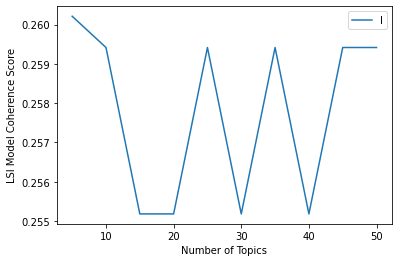


LSI coherence scores
LSI Model[0] ~> N-Topics ~>  5 has Coherence Value of ~> 0.2602
LSI Model[1] ~> N-Topics ~> 10 has Coherence Value of ~> 0.2594
LSI Model[2] ~> N-Topics ~> 15 has Coherence Value of ~> 0.2552
LSI Model[3] ~> N-Topics ~> 20 has Coherence Value of ~> 0.2552
LSI Model[4] ~> N-Topics ~> 25 has Coherence Value of ~> 0.2594
LSI Model[5] ~> N-Topics ~> 30 has Coherence Value of ~> 0.2552
LSI Model[6] ~> N-Topics ~> 35 has Coherence Value of ~> 0.2594
LSI Model[7] ~> N-Topics ~> 40 has Coherence Value of ~> 0.2552
LSI Model[8] ~> N-Topics ~> 45 has Coherence Value of ~> 0.2594
LSI Model[9] ~> N-Topics ~> 50 has Coherence Value of ~> 0.2594





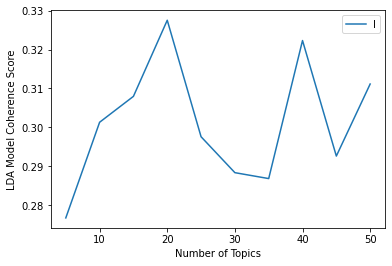



LDA coherence scores
LDA Model[0] ~> N-Topics ~>  5 has Coherence Value of ~> 0.2767
LDA Model[1] ~> N-Topics ~> 10 has Coherence Value of ~> 0.3013
LDA Model[2] ~> N-Topics ~> 15 has Coherence Value of ~> 0.308
LDA Model[3] ~> N-Topics ~> 20 has Coherence Value of ~> 0.3275
LDA Model[4] ~> N-Topics ~> 25 has Coherence Value of ~> 0.2976
LDA Model[5] ~> N-Topics ~> 30 has Coherence Value of ~> 0.2884
LDA Model[6] ~> N-Topics ~> 35 has Coherence Value of ~> 0.2868
LDA Model[7] ~> N-Topics ~> 40 has Coherence Value of ~> 0.3223
LDA Model[8] ~> N-Topics ~> 45 has Coherence Value of ~> 0.2926
LDA Model[9] ~> N-Topics ~> 50 has Coherence Value of ~> 0.3111
CPU times: user 3min 23s, sys: 39.2 s, total: 4min 2s
Wall time: 6min 40s


In [59]:
%%time 

limit = 51; start = 5; step = 5
lsicoherences = []
lsimodels = []
ldacoherences = []
ldamodels = []

for N in range(start, limit, step):
    # LSI
    lsimodel = LsiModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary)
    lsimodels.append(lsimodel)
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
    lsicoherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    lsicoherences.append((lsicoherence))
    # LDA
    ldamodel = LdaModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary)
    ldamodels.append(ldamodel)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    ldacoherences.append((ldacoherence))

# HDP
hdpmodel = HdpModel(corpus=corpus, id2word=id2word_dictionary)
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
hdpcoherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()


# Plot the number of topics based on LSI coherence score
x = range(start, limit, step)
plt.plot(x, lsicoherences)
plt.xlabel('Number of Topics')
plt.ylabel('LSI Model Coherence Score')
plt.legend('lsicoherences', loc='best')
plt.show()  
# Print the LSI coherence scores
print('\nLSI coherence scores')
idx = 0
for n, cv in zip(x, lsicoherences):
    print(f'LSI Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

print('\n\n')

# Plot the number of topics based on LDA coherence score
x = range(start, limit, step)
plt.plot(x, ldacoherences)
plt.xlabel('Number of Topics')
plt.ylabel('LDA Model Coherence Score')
plt.legend('ldacoherences', loc='best')
plt.show()  
# Print the LDA coherence scores
print('\n\nLDA coherence scores')
idx = 0
for n, cv in zip(x, ldacoherences):
    print(f'LDA Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

In [60]:
# INTENTIONAL EXCEPTION
raise Exception('Select the BEST MODELS')

Exception: Select the BEST MODELS

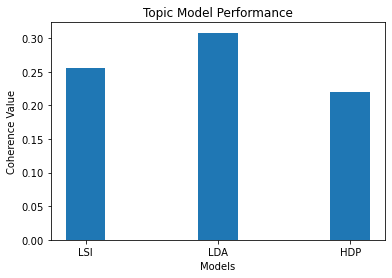

In [61]:
def evaluate_coherence_bargraph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.3, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.title('Topic Model Performance')
    plt.show
    
evaluate_coherence_bargraph([lsicoherences[2], ldacoherences[2], hdpcoherence], ['LSI', 'LDA', 'HDP'])

In [62]:
# Select the BEST model and print the topics
# TODO: best_model = {lsi, lda, hdp}models[2]   e.g. best_model = ldamodels[2]

best_model = ldamodels[2]
topics = best_model.show_topics(formatted=False)
best_model.print_topics(num_words=10)

[(0,
  '0.011*"government" + 0.011*"city" + 0.009*"health" + 0.008*"case" + 0.005*"country" + 0.005*"also" + 0.005*"first" + 0.005*"dose" + 0.005*"national" + 0.004*"local"'),
 (1,
  '0.013*"health" + 0.010*"government" + 0.008*"worker" + 0.008*"country" + 0.006*"get" + 0.006*"trial" + 0.006*"dose" + 0.005*"year" + 0.005*"sinovac" + 0.005*"people"'),
 (2,
  '0.014*"city" + 0.009*"government" + 0.008*"dose" + 0.007*"also" + 0.006*"country" + 0.006*"vaccination" + 0.006*"health" + 0.005*"astrazeneca" + 0.005*"first" + 0.005*"coronavirus"'),
 (3,
  '0.021*"city" + 0.014*"vaccination" + 0.009*"case" + 0.009*"government" + 0.007*"health" + 0.006*"also" + 0.006*"country" + 0.006*"dose" + 0.006*"percent" + 0.005*"vaccinate"'),
 (4,
  '0.012*"dose" + 0.012*"city" + 0.010*"health" + 0.009*"vaccination" + 0.009*"government" + 0.008*"first" + 0.007*"get" + 0.007*"country" + 0.006*"also" + 0.006*"give"'),
 (5,
  '0.010*"also" + 0.009*"health" + 0.009*"vaccination" + 0.009*"government" + 0.007*"get

In [63]:

# from collections import Counter
# import matplotlib.colors as mcolors


# data_flat = [w for w_list in data for w in w_list]
# counter = Counter(data_flat)

# out = []
# for i, topic in topics:
#     for word, weight in topic:
#         out.append([word, i , weight, counter[word]])

# dff = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# # Plot Word Count and Weights of Topic Keywords
# fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
# for i, ax in enumerate(axes.flatten()):
#     ax.bar(x='word', height="word_count", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
#     ax_twin = ax.twinx()
#     ax_twin.bar(x='word', height="importance", data=dff.loc[dff.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
#     ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
#     ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
#     ax.tick_params(axis='y', left=False)
#     ax.set_xticklabels(dff.loc[dff.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
#     ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# fig.tight_layout(w_pad=2)    
# fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
# plt.show()
# dff

In [64]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus, id2word_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.028460  0.012280       1        1  16.774776
13     0.021330  0.003125       2        1  13.609489
14    -0.018846  0.002049       3        1  12.656465
5     -0.002006  0.010281       4        1  10.080148
11     0.014264  0.018321       5        1   9.226987
6      0.002470  0.004513       6        1   6.969735
4     -0.003156  0.005119       7        1   5.724357
8     -0.006805  0.005509       8        1   4.409742
7      0.009722  0.006749       9        1   3.917551
9     -0.024182 -0.027841      10        1   3.814368
1      0.019445  0.010955      11        1   3.624187
12    -0.003389 -0.000576      12        1   3.194798
10     0.025205 -0.035015      13        1   2.387596
2     -0.005254 -0.009508      14        1   2.055945
0     -0.000335 -0.005961      15        1   1.553857, topic_info=            Term         Freq        Total Category  logprob  loglift
659         city  3238.000000  3238.000000  Default  30.0000  30.0000
146   government  2620.000000  2620.000000  Default  29.0000  29.0000
151       health  2910.000000  2910.000000  Default  28.0000  28.0000
105         dose  2431.000000  2431.000000  Default  27.0000  27.0000
343  vaccination  2326.000000  2326.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
220         need    12.597683   845.087963  Topic15  -5.9082  -0.0415
702       people    13.729546  1044.764395  Topic15  -5.8221  -0.1676
525       worker    13.605957  1134.453954  Topic15  -5.8312  -0.2590
343  vaccination    14.906754  2326.668708  Topic15  -5.7398  -0.8859
143          get    13.282201  1477.609538  Topic15  -5.8552  -0.5473

[1241 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3660       1  0.459939     abante
3          1  0.181350     accord
3          2  0.125550     accord
3          3  0.137756     accord
3          4  0.108112     accord
...      ...       ...        ...
1821      13  0.026937  zamboanga
1821      14  0.008979  zamboanga
1821      15  0.017958  zamboanga
15572     10  0.464190      zcpos
12257      7  0.569312      zobel

[4195 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 14, 15, 6, 12, 7, 5, 9, 8, 10, 2, 13, 11, 3, 1])

## Finding the dominant topic in each sentence

In [65]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_id', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
# df_dominant_topic = df_dominant_topic.drop('document_id', axis=1)

# Show
# print(f'{df_dominant_topic.shape[0]} == {df.shape[0]}')
df_dominant_topic

,document_id,dominant_topic,topic_percentage_contribution,keywords,text
0,0,5.0,0.9600,"also, health, vaccination, government, get, ci...","[government, need, key, measure, indemnificati..."
1,1,14.0,0.6785,"city, dose, government, health, also, country,...","[update, march, finally, begin, legally, roll,..."
2,2,11.0,0.5956,"health, dose, worker, first, vaccination, sino...","[update, malacanang, dose, global, facility, h..."
3,3,1.0,0.7143,"health, government, worker, country, get, tria...","[update, low, efficacy, trial, brazil, lead, e..."
4,4,11.0,0.8057,"health, dose, worker, first, vaccination, sino...","[rd, update, arrival, donate, china, pave, way..."
...,...,...,...,...,...
1493,1493,9.0,0.8713,"city, government, health, dose, also, vaccinat...","[zamboanga, city, maria, salazar, write, educa..."
1494,1494,14.0,0.9887,"city, dose, government, health, also, country,...","[zamboanga, city, mayor, salazar, convene, tas..."
1495,1495,14.0,0.9889,"city, dose, government, health, also, country,...","[zamboangueno, athlete, reap, medal, recent, n..."
1496,1496,14.0,0.9928,"city, dose, government, health, also, country,...","[delegation, city, recently, conclude, weightl..."


## Find the most representative document for each topic

In [66]:
# Group top N sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['percentage_contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['topic_id', "topic_percentage_contribution", "keywords", "text"]

# ### Save the dataset as CSV
# sent_topics_sorteddf.to_csv('datasets/topics.csv')

# Show
print(sent_topics_sorteddf.shape)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf

(15, 4)


,topic_id,topic_percentage_contribution,keywords,text
0,0.0,0.9948,"government, city, health, case, country, also, first, dose, national, local","[department, energy, doe, direct, power, generation, company, ensure, reliable, stable, electric, power, supply, government, rollout, late, directive, complement, early, doe, order, power, distribution, utility, issue, february, purpose, advisory, date, march, energy, secretary, alfonso, cusi, order, power, generation, firm, include, government, control, corporation, well, private_sector, operate, generation, facility, undertake, following, ensure, availability, generate, facility, maximum, dependable, capacity, compliance, grid, operating, maintenance, program, manage, water, reservoir, optimal, production, hydroelectric, power, plant, need, secure, adequate, fuel, supply, maintain, reasonable, fuel, inventory, arrange, back, personnel, power, plant, additional, maintenance, crew, assist, case, emergency, augment, security, force, major, power, plant, installation, need, ensure, emergency, response, ...]"
1,1.0,0.9969,"health, government, worker, country, get, trial, dose, year, sinovac, people","[health, worker, convince, community, get, vaccinate, sell, mapupuno, head, health, team, accord, rumor, circulate, coronavirus, allow, president, duterte, kill, people, push, button, elsewhere, country, memory, dengue, ban, locally, put, people, idea, immunization, even, campaign, begin, many, kid, get, sick, receive, year, old, crisanta, ill, fate, dengue, mosquito, bear, disease, deadly, afraid, novel_coronavirus, even, afraid, vaccination, due, start, immunization, next, month, suffer, southeast, asias, second, bad, outbreak, coronavirus, infection, death, official, acknowledge, uphill, struggle, persuade, many, people, take, top, logistical, difficulty, reach, inhabited, island, precarious, health, system, southeast_asian, archipelago, messaging, concrete, evidence, base, encourage, people, receive, health, undersecretary, rosario, tell, reuters, ...]"
2,2.0,0.9956,"city, government, dose, also, country, vaccination, health, astrazeneca, first, coronavirus","[newly, elect, official, leyte, city, swear, office, separate, venue, june, leyte, district_representative, ferdinand, martin_romualdez, wife, representative, yedda, romualdez, tingog, party, list, together, tacloban, councilor, take, oath, office, historic, price, mansion, tacloban, elect, official, different, district, municipality, province, lead, elect, governor, leopoldo, petilla, mass, oath, take, oriental, leyte, hotel, palo, town, kilometer, away, city, honor, privilege, back, serve, romualdez, president, constitution, association, philconsa, honor, honor, god, serve, faithfully, dream, objective, vision, make, leyte, first, number, romualdez, take, oath, captain, malinao, barangay, romualdez, report, strong, contender, house, speakership, call, constituent, support, continue, legislative, work, accord, lawmaker, family, humble, honor, give, public, want, ...]"
3,3.0,0.9985,"city, vaccination, case, government, health, also, country, dose, percent, vaccinate","[dose, astrazeneca, set, arrive, central_visayas, march, confirm, department, health, spokesperson, dr_mary, jean, project, balik, pbb, briefing, march, sixth, day, vaccination, rollout, region, country, worldwide, third, asean, member, nation, receive, covax_facility, first, day, global, rollout, donate, covax_facility, transport, unicef, commercial_flight, klm, royal, dutch, airline, early, week, astrazeneca, store, doh, cold_chain, storage, loreche, still, planning, stage, distribution, doh, emphasize, healthcare, worker, hcw, get, jab, first, excess, roll, hcws, age, coronavac, jab, private, hospital, cebu, start, vaccinate, healthcare, worker, coronavac, develop, chinese, company, sinovac_biotech, ltd, provide, national, government, first, private, hospital, cebu, vaccinate, frontline, worker, cebu, city, branch, hospital, march, allocate, dose, coronavac, ...]"


## Topic distribution across documents

In [67]:
pd.reset_option('^display', silent=True)

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['dominant_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['dominant_topic', 'topic_keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['dominant_topic', 'topic_keywords', 'num_documents', 'percentage_documents']

# Show
# df_dominant_topics = df_dominant_topics[~df_dominant_topics['num_documents'].isna()][['topic_keywords']]
df_dominant_topics

,dominant_topic,topic_keywords,num_documents,percentage_documents
0.0,5.0,"also, health, vaccination, government, get, ci...",23.0,0.0154
1.0,14.0,"city, dose, government, health, also, country,...",53.0,0.0354
2.0,11.0,"health, dose, worker, first, vaccination, sino...",37.0,0.0247
3.0,1.0,"health, government, worker, country, get, tria...",258.0,0.1722
4.0,11.0,"health, dose, worker, first, vaccination, sino...",81.0,0.0541
...,...,...,...,...
1493.0,9.0,"city, government, health, dose, also, vaccinat...",NaN,NaN
1494.0,14.0,"city, dose, government, health, also, country,...",NaN,NaN
1495.0,14.0,"city, dose, government, health, also, country,...",NaN,NaN
1496.0,14.0,"city, dose, government, health, also, country,...",NaN,NaN


# FINAL DF

In [68]:
sia = SentimentIntensityAnalyzer()

def get_vader_polarity(text):
    return sia.polarity_scores(text)['compound']

def get_vader_negativity(text):
    return sia.polarity_scores(text)['neg']

def get_vader_neutrality(text):
    return sia.polarity_scores(text)['neu']

def get_vader_positivity(text):
    return sia.polarity_scores(text)['pos']

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_analysis(score):
    if score <= -0.05:
        return 'Negative'
    elif score >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [69]:
df = pd.concat([df, df_dominant_topic.reindex(df.index)], axis=1).drop('document_id', axis=1)
df

,urls,titles,authors,published_dates,articles_content,news_org,articles_summary,dominant_topic,topic_percentage_contribution,keywords,text
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler,Why do we need an indemnification fund?An inde...,5.0,0.9600,"also, health, vaccination, government, get, ci...","[government, need, key, measure, indemnificati..."
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler,"Now, the Philippines is just weeks away from s...",14.0,0.6785,"city, dose, government, health, also, country,...","[update, march, finally, begin, legally, roll,..."
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler,"(UPDATED) Malacañang says 487,200 doses from t...",11.0,0.5956,"health, dose, worker, first, vaccination, sino...","[update, malacanang, dose, global, facility, h..."
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler,FDA Director General Eric Domingo made the ann...,1.0,0.7143,"health, government, worker, country, get, tria...","[update, low, efficacy, trial, brazil, lead, e..."
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler,(3rd UPDATE) The arrival of donated COVID-19 v...,11.0,0.8057,"health, dose, worker, first, vaccination, sino...","[rd, update, arrival, donate, china, pave, way..."
...,...,...,...,...,...,...,...,...,...,...,...
1493,https://www.sunstar.com.ph/article/1884896/Zam...,Review on blended modular learning sought,sunstar,2021-02-04 00:00:00,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,sunstar,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,9.0,0.8713,"city, government, health, dose, also, vaccinat...","[zamboanga, city, maria, salazar, write, educa..."
1494,https://www.sunstar.com.ph/article/1746415/Zam...,Illegal ports proliferate in Zamboanga City,sunstar,2018-06-04 00:00:00,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,sunstar,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,14.0,0.9887,"city, dose, government, health, also, country,...","[zamboanga, city, mayor, salazar, convene, tas..."
1495,https://www.sunstar.com.ph/article/1742363,"Zamboanga athletes win medals in swimming, wei...",BONG GARCIA,2018-05-09 00:00:00,ZAMBOANGUEÑO athletes have reaped medals durin...,sunstar,ZAMBOANGUEÑO athletes have reaped medals durin...,14.0,0.9889,"city, dose, government, health, also, country,...","[zamboangueno, athlete, reap, medal, recent, n..."
1496,https://www.sunstar.com.ph/article/1815861/Zam...,Zamboanga weightlifters harvest 48 medals,BONG GARCIA,2019-07-25 00:00:00,THE delegation of Zamboanga City to the recent...,sunstar,THE delegation of Zamboanga City to the recent...,14.0,0.9928,"city, dose, government, health, also, country,...","[delegation, city, recently, conclude, weightl..."


In [70]:
# Data Analysis
df['polarity'] = df['text'].str.join(' ').apply(get_vader_polarity)
df['negativity'] = df['text'].str.join(' ').apply(get_vader_negativity)
df['neutrality'] = df['text'].str.join(' ').apply(get_vader_neutrality)
df['positivity'] = df['text'].str.join(' ').apply(get_vader_positivity)
df['subjectivity'] = df['text'].str.join(' ').apply(get_subjectivity)
df['analysis'] = df['polarity'].apply(get_analysis)

# Save the model dataset as CSV
FILENAME = 'datasets/model.csv'
df.to_csv(FILENAME, index=False)


In [71]:
### Read the MODEL dataset
df = pd.read_csv(FILENAME)
# df['published_dates'] = pd.to_datetime(df['published_dates'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   urls                           1498 non-null   object 
 1   titles                         1498 non-null   object 
 2   authors                        1498 non-null   object 
 3   published_dates                1498 non-null   object 
 4   articles_content               1498 non-null   object 
 5   news_org                       1498 non-null   object 
 6   articles_summary               1498 non-null   object 
 7   dominant_topic                 1498 non-null   float64
 8   topic_percentage_contribution  1498 non-null   float64
 9   keywords                       1498 non-null   object 
 10  text                           1498 non-null   object 
 11  polarity                       1498 non-null   float64
 12  negativity                     1498 non-null   f

,urls,titles,authors,published_dates,articles_content,news_org,articles_summary,dominant_topic,topic_percentage_contribution,keywords,text,polarity,negativity,neutrality,positivity,subjectivity,analysis
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler,Why do we need an indemnification fund?An inde...,5.0,0.9600,"also, health, vaccination, government, get, ci...","['government', 'need', 'key', 'measure', 'inde...",0.9590,0.088,0.791,0.120,0.365431,Positive
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler,"Now, the Philippines is just weeks away from s...",14.0,0.6785,"city, dose, government, health, also, country,...","['update', 'march', 'finally', 'begin', 'legal...",0.9899,0.023,0.860,0.116,0.366555,Positive
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler,"(UPDATED) Malacañang says 487,200 doses from t...",11.0,0.5956,"health, dose, worker, first, vaccination, sino...","['update', 'malacanang', 'dose', 'global', 'fa...",0.8969,0.066,0.780,0.153,0.336905,Positive
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler,FDA Director General Eric Domingo made the ann...,1.0,0.7143,"health, government, worker, country, get, tria...","['update', 'low', 'efficacy', 'trial', 'brazil...",0.9803,0.100,0.713,0.187,0.380207,Positive
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler,(3rd UPDATE) The arrival of donated COVID-19 v...,11.0,0.8057,"health, dose, worker, first, vaccination, sino...","['rd', 'update', 'arrival', 'donate', 'china',...",0.7076,0.082,0.826,0.092,0.299074,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,https://www.sunstar.com.ph/article/1884896/Zam...,Review on blended modular learning sought,sunstar,2021-02-04 00:00:00,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,sunstar,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,9.0,0.8713,"city, government, health, dose, also, vaccinat...","['zamboanga', 'city', 'maria', 'salazar', 'wri...",-0.8519,0.165,0.781,0.053,0.104762,Negative
1494,https://www.sunstar.com.ph/article/1746415/Zam...,Illegal ports proliferate in Zamboanga City,sunstar,2018-06-04 00:00:00,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,sunstar,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,14.0,0.9887,"city, dose, government, health, also, country,...","['zamboanga', 'city', 'mayor', 'salazar', 'con...",-0.7717,0.082,0.878,0.040,0.355000,Negative
1495,https://www.sunstar.com.ph/article/1742363,"Zamboanga athletes win medals in swimming, wei...",BONG GARCIA,2018-05-09 00:00:00,ZAMBOANGUEÑO athletes have reaped medals durin...,sunstar,ZAMBOANGUEÑO athletes have reaped medals durin...,14.0,0.9889,"city, dose, government, health, also, country,...","['zamboangueno', 'athlete', 'reap', 'medal', '...",0.9666,0.000,0.789,0.211,0.216667,Positive
1496,https://www.sunstar.com.ph/article/1815861/Zam...,Zamboanga weightlifters harvest 48 medals,BONG GARCIA,2019-07-25 00:00:00,THE delegation of Zamboanga City to the recent...,sunstar,THE delegation of Zamboanga City to the recent...,14.0,0.9928,"city, dose, government, health, also, country,...","['delegation', 'city', 'recently', 'conclude',...",0.9898,0.000,0.750,0.250,0.512500,Positive


In [72]:
df[['articles_content','articles_summary']]

,articles_content,articles_summary
0,"MANILA, PHILIPPINES\nThe Philippine government...",Why do we need an indemnification fund?An inde...
1,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...","Now, the Philippines is just weeks away from s..."
2,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...","(UPDATED) Malacañang says 487,200 doses from t..."
3,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",FDA Director General Eric Domingo made the ann...
4,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",(3rd UPDATE) The arrival of donated COVID-19 v...
...,...,...
1493,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...,ZAMBOANGA City Maria Isabelle Climaco-Salazar ...
1494,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...,ZAMBOANGA City Mayor Maria Isabelle Climaco-Sa...
1495,ZAMBOANGUEÑO athletes have reaped medals durin...,ZAMBOANGUEÑO athletes have reaped medals durin...
1496,THE delegation of Zamboanga City to the recent...,THE delegation of Zamboanga City to the recent...


In [73]:
import plotly.express as px

fig = px.scatter(df,
                x='polarity',
                y='subjectivity',
                color='analysis',
                size='subjectivity'
                )

fig.update_layout(title='Sentiment Analysis',
                shapes=[dict(
                    type='line',
                    yref='paper', y0=0, y1=1,
                    xref='x', x0=0, x1=0
                )]
                )

fig.show()

In [21]:
# def to_english(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='en'))
#     except:
#         pass
#     return result

# def to_tagalog(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='tl'))
#     except:
#         pass
#     return result
